In [1]:
# Script for Plotting the Case Study Figures

In [2]:
from datetime import datetime
from itertools import product
from pathlib import Path
from typing import Any
import seaborn as sns 
import joblib
# import keras
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
# import plotly.express as px
# import plotly.graph_objects as go
# import streamlit as st
# import tensorflow as tf
import xarray as xr
#from sklearn import metrics
# from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
# import dask.dataframe as dd

# # Read the Parquet file using Dask
# df = dd.read_parquet('/home/levin/github/ml-for-cloudphase-amt-2024/src/analysis/data/parallel_nsa_cloudy_predictions.parquet')

# # Print the first few rows
# column_index = df.columns
# print(f"Column names as Index object: {column_index}")

In [4]:
# Specify the columns you want to load
columns_to_load = ['rf_balanced_confidence','mlp_balanced_confidence','cnn_confidence','cloud_phase', 'rf_balanced','mlp_balanced','cnn']

# Read only the specified columns from the Parquet file
df = pd.read_parquet('/home/levin/github/ml-for-cloudphase-amt-2024/src/analysis/data/parallel_nsa_cloudy_predictions.parquet', columns=columns_to_load)

# Now you can work with just these columns
print(df.head())

                            rf_balanced_confidence  mlp_balanced_confidence  \
time                height                                                    
2021-01-01 00:57:00 0.16                      0.55                 0.676128   
                    0.19                      0.52                 0.544946   
                    0.22                      0.55                 0.810537   
                    0.25                      0.59                 0.521957   
2021-01-01 00:57:30 0.16                      0.51                 0.513489   

                            cnn_confidence cloud_phase rf_balanced  \
time                height                                           
2021-01-01 00:57:00 0.16          0.793064         ice      liquid   
                    0.19          0.910763         ice      liquid   
                    0.22          0.926132         ice         ice   
                    0.25          0.895370         ice      liquid   
2021-01-01 00:57:30 0.16  

# Code Finalizing

In [5]:
plt.rcParams['font.family'] = 'serif'

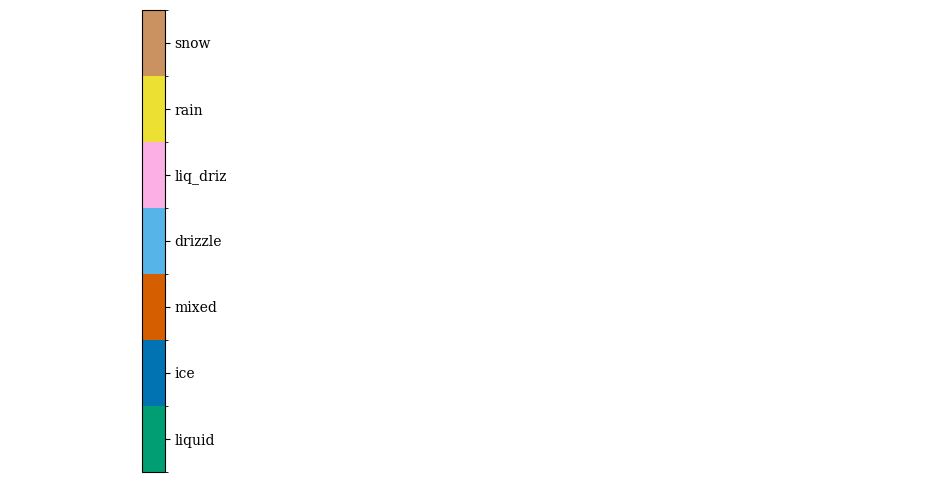

In [6]:
_cblind = sns.color_palette("colorblind")

def create_small_colorbar_vert(axs):
    # Define the custom colors for each phase
    custom_colors = [
        _cblind[2],  # liquid (dark purple from viridis)
        _cblind[0],  # ice (blue from viridis)
        _cblind[3],  # mixed (greenish-blue from viridis)
        _cblind[9],  # drizzle (light green from viridis)
        _cblind[6],  # liq_driz (yellow from viridis)
        _cblind[8],  # rain (brighter yellow)
        _cblind[5],  # snow (orange-yellow)
    ]

    # Create a colormap with distinct colors for each integer value
    cmap = mcolors.ListedColormap(custom_colors)

    # Create a norm for the colorbar to map integer values to the colormap
    bounds = np.arange(1, 9)  # Values 1 to 7 (corresponding to the phases)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Define the phase labels
    PHASE_MAP_small = {
        1: "liquid",
        2: "ice",
        3: "mixed",
        4: "drizzle",
        5: "liq_driz",
        6: "rain",
        7: "snow"
    }

    

    # Create the colorbar using the colormap, norm, and set the ticks and labels
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=axs, ticks=np.arange(1, 8), pad = -5)
    # cbar.set_label('Class Phases')
    cbar.set_ticks(np.arange(1, 8)+.5)  # Set ticks for each phase
    cbar.ax.set_yticklabels([PHASE_MAP_small[i] for i in range(1, 8)])  # Set custom labels

    
# Create a figure and axis to display the colorbar
fig, ax = plt.subplots(figsize=(2,6))
create_small_colorbar_vert(ax)
ax.axis('off')
fig.savefig(Path("/home/goldberger/ML_Plotting") / f"Vert_Colorbar.png", dpi=300, bbox_inches='tight')
plt.show()


In [7]:
custom_colors = [
    _cblind[2],  # liquid (dark purple from viridis)
    _cblind[0],  # ice (blue from viridis)
    _cblind[3],  # mixed (greenish-blue from viridis)
    _cblind[9],  # drizzle (light green from viridis)
    _cblind[6],  # liq_driz (yellow from viridis)
    _cblind[8],  # rain (brighter yellow)
    _cblind[5],  # snow (orange-yellow)
]
cmap = mcolors.ListedColormap(custom_colors)

In [8]:
def plot_norm(ax, df, var,cmap):
    # Add a new column to categorize 'cnn_confidence' into bins
    df['confidence_bin'] = pd.cut(df[var+'_confidence'], bins=bins, right=False)#, labels=bin_labels)
    # Group by the confidence bin and 'cnn' values and count the occurrences
    grouped = df.groupby(['confidence_bin', var]).size().unstack(fill_value=0)
    # Normalize the counts to proportions (divide by the total count per bin)
    grouped_normalized = grouped.div(grouped.sum(axis=1), axis=0)
    # Plot the results
    grouped_normalized.plot(ax=ax,kind='bar', stacked=True, cmap = cmap)
    # Create the right y-axis (twin axis)
    ax2 = ax.twinx()
    # Plot the results
    grouped.sum(axis=1).plot(ax=ax2, color = 'black')

    ax2.set_ylabel('Total Correct')
    ax.set_ylabel('\n Proportions')
    # ax.set_xticklabels(bin_labels, rotation=45)
    ax2.set_ylim([0, 6e7])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.get_legend().set_visible(False)

def plt_conf(ax1, df, var):
    # Add a new column to categorize 'cnn_confidence' into bins
    df['confidence_bin'] = pd.cut(df[var + '_confidence'], bins=bins, labels=bin_labels, right=False)
    # Create a new column to check if the guess is correct (True if cnn == cloud_phase)
    df['correct_guess'] = df[var] == df['cloud_phase']
    # Group by confidence bin and calculate the percentage of correct guesses
    correct_guesses = df.groupby('confidence_bin')['correct_guess'].mean() * 100  # Multiply by 100 for percentage
    if 'cnn' in var:
        ax1.plot(correct_guesses.index, correct_guesses.values, marker='s', linestyle='-', label = 'CNN')
    elif 'mlp' in var:
        ax1.plot(correct_guesses.index, correct_guesses.values, marker='o', linestyle='-', label = 'MLP')
    else:
        ax1.plot(correct_guesses.index, correct_guesses.values, marker='d', linestyle='-', label = 'RF')

/tmp/ipykernel_32532/3378113490.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correct_guesses = df.groupby('confidence_bin')['correct_guess'].mean() * 100  # Multiply by 100 for percentage
/tmp/ipykernel_32532/3378113490.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correct_guesses = df.groupby('confidence_bin')['correct_guess'].mean() * 100  # Multiply by 100 for percentage
/tmp/ipykernel_32532/3378113490.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to 

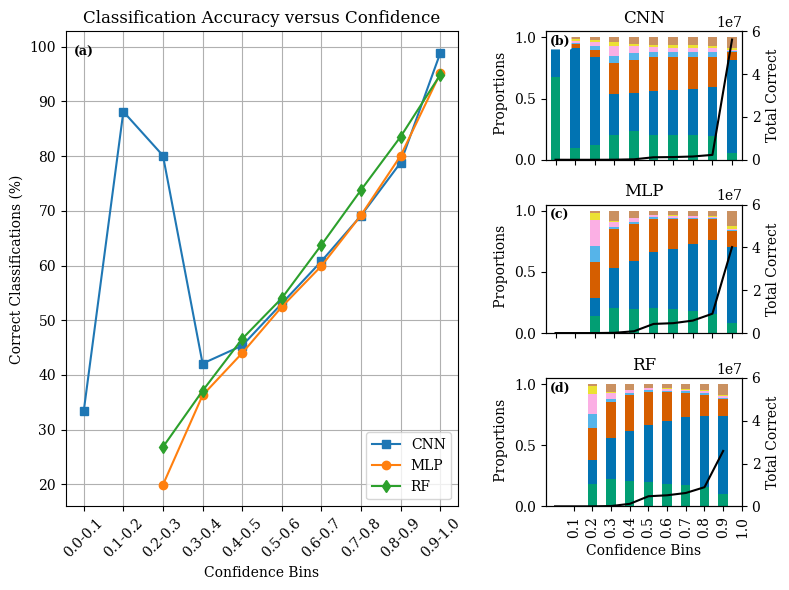

In [9]:
# Create bins for the confidence score
bins = [i/10 for i in range(11)]  # [0.0, 0.1, 0.2, ..., 1.0]
bin_labels = [f"{i/10:.1f}-{(i+1)/10:.1f}" for i in range(10)]

fig = plt.figure(figsize=(8, 6))

gs = gridspec.GridSpec(3, 2, width_ratios=[2, 1])

ax1 = plt.subplot(gs[:, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[2, 1])

# ax1.set_title('Large Plot')
# ax2.set_title('Small Plot 1')
# ax3.set_title('Small Plot 2')
# ax4.set_title('Small Plot 3')

##################################################
# AX1
# Function for calculating and plotting
# Run function in a loop
conf = ['cnn','mlp_balanced','rf_balanced']
for confidence in conf:
    plt_conf(ax1, df,confidence)

# Plot Details
ax1.set_title('Classification Accuracy versus Confidence')
ax1.set_xlabel('Confidence Bins')
ax1.set_ylabel('Correct Classifications (%)')
ax1.set_xticklabels(bin_labels, rotation=45)
ax1.grid(True)
ax1.legend(loc='lower right')

#######################################################
# AX2
plot_norm(ax2, df, 'cnn',cmap)
ax2.set_title('CNN')
# ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# AX3
plot_norm(ax3, df, 'mlp_balanced',cmap)
ax3.set_title('MLP')

# AX4
plot_norm(ax4, df, 'rf_balanced',cmap)
ax4.set_title('RF')
ax4.set_xticks([1 * i for i in range(1, 11)])  # Set x-ticks from 0.1 to 1
ax4.set_xticklabels([f'{0.1 * i:.1f}' for i in range(1, 11)])  # Set labels .1, .2, ..., 1
ax4.set_xlabel('Confidence Bins')
#ax4.legend(bbox_to_anchor=(.5, -1), loc='upper right')

########################################################
# Add letter to top-left of each subplot

ax1.text(x=0.02,y=0.97,s='(a)',transform=ax1.transAxes,verticalalignment="top",horizontalalignment="left",fontweight="bold",fontsize=9)
ax2.text(x=0.02,y=0.97,s='(b)',transform=ax2.transAxes,verticalalignment="top",horizontalalignment="left",fontweight="bold",fontsize=9, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1'))
ax3.text(x=0.02,y=0.97,s='(c)',transform=ax3.transAxes,verticalalignment="top",horizontalalignment="left",fontweight="bold",fontsize=9)
ax4.text(x=0.02,y=0.97,s='(d)',transform=ax4.transAxes,verticalalignment="top",horizontalalignment="left",fontweight="bold",fontsize=9)

plt.tight_layout()
fig.savefig(Path("/home/goldberger/ML_Plotting") / f"Figure_S2_Revised.png", dpi=300, bbox_inches='tight')

plt.show()

/tmp/ipykernel_32532/3378113490.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correct_guesses = df.groupby('confidence_bin')['correct_guess'].mean() * 100  # Multiply by 100 for percentage
/tmp/ipykernel_32532/3378113490.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correct_guesses = df.groupby('confidence_bin')['correct_guess'].mean() * 100  # Multiply by 100 for percentage
/tmp/ipykernel_32532/3378113490.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to 

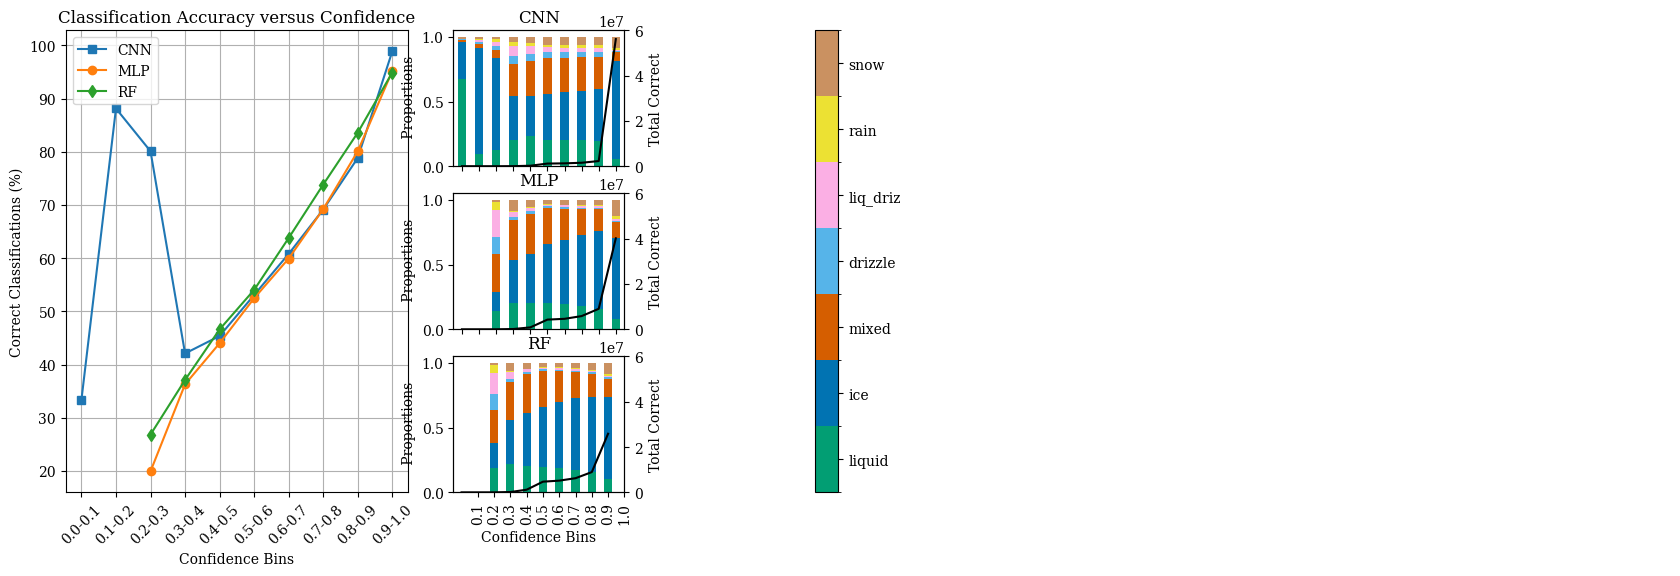

In [10]:
# Create bins for the confidence score
bins = [i/10 for i in range(11)]  # [0.0, 0.1, 0.2, ..., 1.0]
bin_labels = [f"{i/10:.1f}-{(i+1)/10:.1f}" for i in range(10)]

fig = plt.figure(figsize=(10, 6))

gs = gridspec.GridSpec(3, 3, width_ratios=[2, 1,1])

ax1 = plt.subplot(gs[:, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[2, 1])
ax5 = plt.subplot(gs[:, 2])

##################################################
# AX1
# Function for calculating and plotting
# Run function in a loop
conf = ['cnn','mlp_balanced','rf_balanced']
for confidence in conf:
    plt_conf(ax1, df,confidence)

# Plot Details
ax1.set_title('Classification Accuracy versus Confidence')
ax1.set_xlabel('Confidence Bins')
ax1.set_ylabel('Correct Classifications (%)')
ax1.set_xticklabels(bin_labels, rotation=45)
ax1.grid(True)
ax1.legend()

#######################################################
# AX2
plot_norm(ax2, df, 'cnn',cmap)
ax2.set_title('CNN')
# ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# AX3
plot_norm(ax3, df, 'mlp_balanced',cmap)
ax3.set_title('MLP')

# AX4
plot_norm(ax4, df, 'rf_balanced',cmap)
ax4.set_title('RF')
ax4.set_xticks([1 * i for i in range(1, 11)])  # Set x-ticks from 0.1 to 1
ax4.set_xticklabels([f'{0.1 * i:.1f}' for i in range(1, 11)])  # Set labels .1, .2, ..., 1
ax4.set_xlabel('Confidence Bins')
#ax4.legend(bbox_to_anchor=(.5, -1), loc='upper right')

########################################################
create_small_colorbar_vert(ax5)
ax5.axis('off')

#############################################

plt.tight_layout()
plt.show()